In [1]:
# Some part borrowed from official tutorial https://github.com/pytorch/examples/blob/master/imagenet/main.py
from __future__ import print_function
from __future__ import absolute_import

import os
import numpy as np
import argparse
import importlib
import time
import logging
import warnings
from collections import OrderedDict
import pdb
import importlib

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import models
import data
import trainers
import evaluators
import attacks
from attack_vectors import get_attack_vector
from utils import *

In [2]:
cifar = data.cifar10('./datasets', normalize=False)
#cifar = data.imagenet('./datasets/imagenette2', normalize=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = "cuda:0"
in_channel = 3
num_classes = 10
config_path = './configs/configs_cifar.yml'
#config_path = './configs/configs_imagenet.yml'
ckpt_path = './trained_models/cifar10_WideResNet2810_base/trial_0/checkpoint/checkpoint.pth.tar'
#ckpt_path = './trained_models/imagenette2_ResNet18_trainadv_none/trial0/checkpoint/checkpoint.pth.tar'

In [4]:
model = torch.nn.DataParallel(models.WideResNet2810(in_channel=in_channel, num_classes=num_classes)).cuda().eval()
ckpt_dict = torch.load(ckpt_path, map_location="cpu")["state_dict"]
model.load_state_dict(ckpt_dict)

<All keys matched successfully>

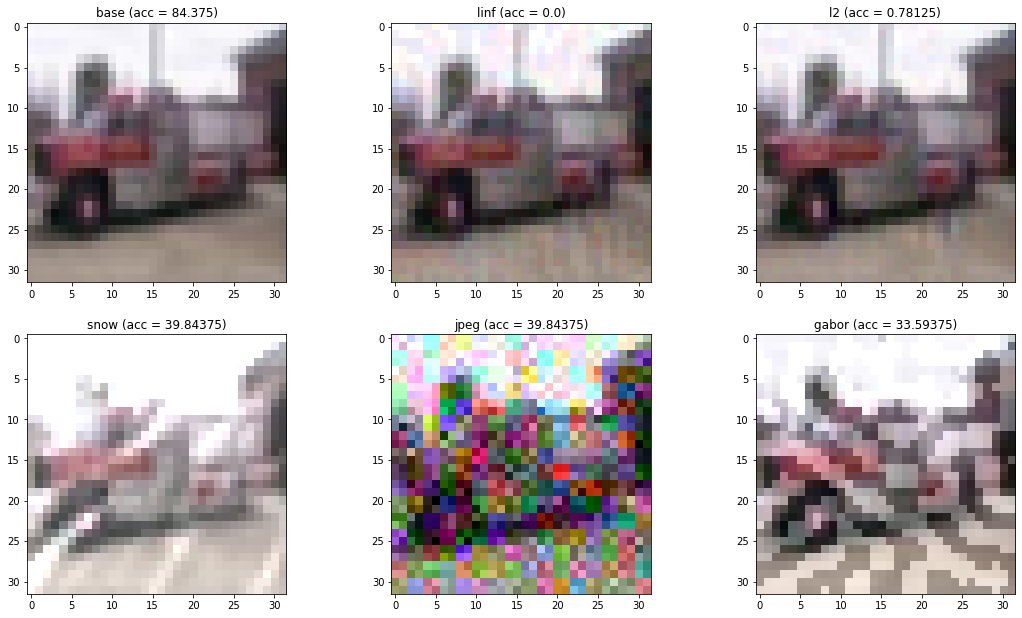

In [16]:
images = []
test_batch = 3
for x,y in enumerate(cifar[1]):
    images.append(y)

image_data = images[test_batch][0].to(device)
image_labels = images[test_batch][1].to(device)

with open(config_path, 'r') as f:
    args = EasyDict(yaml.load(f))

image = 102
attacks = ['linf','l2','snow','jpeg','gabor']
preds = model(image_data)
target = image_labels
acc = accuracy(preds, target, topk=(1,5))
f, axarr = plt.subplots(2,3)
f.set_size_inches(18.5, 10.5)
axarr[0][0].imshow(images[test_batch][0][image].transpose(0,1).transpose(1,2))
axarr[0][0].title.set_text('base (acc = ' + str(float(acc[0])) + ')')

for i in range(len(attacks)):
    attack = get_attack_vector(attacks[i], args.EvalAttack)

    adv_images = attack(model, image_data, image_labels, torch.ones_like(image_labels))

    adv_preds = model(adv_images[0])

    acc = accuracy(adv_preds, target, topk=(1,5))
    
    axarr[(i+1) // 3][(i+1) % 3].imshow(adv_images[0][image].transpose(0,1).transpose(1,2).cpu().detach())
    axarr[(i+1) // 3][(i+1) % 3].title.set_text(attacks[i] + ' (acc = ' + str(float(acc[0])) + ')')